In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ogbn_arixv

In [70]:
cd /content/drive/MyDrive/graph final project

/content/drive/MyDrive/graph final project


In [71]:
# import the pytorch library into environment and check its version
import os
import torch
print("Using torch", torch.__version__)
print(torch.version.cuda)

Using torch 2.1.0+cu118
11.8


In [72]:
# Install torch geometric
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{torch.__version__}.html
!pip install torch-geometric
!pip install ogb
!pip install ogb --upgrade

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html


In [73]:
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
import numpy as np
from torch_geometric.typing import SparseTensor
import pandas as pd

In [74]:
#dataset_name = 'ogbn-products'
dataset_name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name=dataset_name,
                                 transform=T.ToSparseTensor())
data = dataset[0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# If you use GPU, the device should be cuda
print('Device: {}'.format(device))

# data = data.to(device)
# split_idx = dataset.get_idx_split()
# train_idx = split_idx['train'].to(device)

Device: cuda


In [75]:
data

Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=1166243])

In [76]:
# We need to have edge indxes to make a subgraph. We can get those from the adjacency matrix.
data.edge_index = torch.stack([data.adj_t.__dict__["storage"]._row, data.adj_t.__dict__["storage"]._col])

# We will only use the first 100000 nodes.
sub_nodes = 90000
sub_graph = data.subgraph(torch.arange(sub_nodes))

# Update the adjaceny matrix according to the new graph
sub_graph.adj_t = SparseTensor(
    row=sub_graph.edge_index[0],
    col=sub_graph.edge_index[1],
    sparse_sizes=None,
    is_sorted=True,
    trust_data=True,
)

sub_graph = sub_graph.to(device)

sub_graph




Data(num_nodes=90000, x=[90000, 128], node_year=[90000, 1], y=[90000, 1], adj_t=[90000, 90000, nnz=339066], edge_index=[2, 339066])

In [77]:
# Check task type
print('Task type: {}'.format(dataset.task_type))

Task type: multiclass classification


In [78]:
# Spilt data into train validation and test set
split_sizes = [int(sub_nodes*0.8),int(sub_nodes*0.05),sub_nodes - int(sub_nodes*0.8) - int(sub_nodes*0.05)]
indices = torch.arange(sub_nodes)
np.random.shuffle(indices.numpy())
split_idx = {s:t for t,s in zip(torch.split(indices, split_sizes, dim=0), ["train", "valid", "test"])}
split_idx

{'train': tensor([78639, 81348, 22215,  ...,  8754, 58685, 26121]),
 'valid': tensor([47478,  5493, 58186,  ...,  2908, 69421, 87054]),
 'test': tensor([37962, 12195, 85939,  ..., 12272, 65481, 20457])}

In [79]:
print("Number of nodes in train set:", len(split_idx['train']))
print("Number of nodes in valid set:", len(split_idx['valid']))
print("Number of nodes in test set:", len(split_idx['test']))

Number of nodes in train set: 72000
Number of nodes in valid set: 4500
Number of nodes in test set: 13500


In [80]:
# Set batch size for data loaders
batch_size = 32  # You can change this to your preferred batch size

# Split indices for train, validation, and test sets
train_idx = split_idx["train"]
valid_idx = split_idx["valid"]
test_idx = split_idx["test"]

In [81]:
from torch_scatter import scatter_mean,scatter_sum

def mad_gap(x, edge_index):

    #eq 1-2 masked cos similarity
    with torch.no_grad():
        dij = torch.cosine_similarity(x[edge_index[0]], x[edge_index[1]], dim=1, eps=1e-8)
        dij = 1 - dij
        # M^{tgt} = A
        d_bar = scatter_sum(dij, edge_index[1])

    return d_bar.cpu()

# Model

In [82]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds=False):

        super(GCN, self).__init__()

        # A list of GCNConv layers
        self.convs = [
            GCNConv(input_dim, hidden_dim),
        ]

        for _ in range(num_layers-1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))

        self.last_layer = GCNConv(hidden_dim, output_dim)


        # A list of 1D batch normalization layers
        self.bns = []
        for _ in range(num_layers):
            self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        self.convs = torch.nn.ModuleList(self.convs)
        self.bns = torch.nn.ModuleList(self.bns)

        # The log softmax layer
        self.softmax = torch.nn.LogSoftmax()


        # Probability of an element getting zeroed
        self.dropout = dropout

        # Skip classification layer and return node embeddings
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):

        for i in range(len(self.convs)):
            x = self.convs[i](x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.last_layer(x, adj_t)

        if not self.return_embeds:
            x = self.softmax(x)

        return x


In [83]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, heads, return_embeds=False):
        super(GAT, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(input_dim, hidden_dim, heads=heads))
        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_dim * heads, hidden_dim, heads=heads))  # 注意头数的设置

        self.last_layer = GATConv(hidden_dim * heads, output_dim, heads=1)  # 输出层的头数通常为1

        self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dim * heads) for _ in range(num_layers)])

        self.softmax = torch.nn.LogSoftmax(dim=1)
        self.dropout = dropout
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.last_layer(x, edge_index)

        if not self.return_embeds:
            x = self.softmax(x)

        return x


In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import math

class GCNII(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, alpha, lamda, return_embeds=True):
        super(GCNII, self).__init__()

        self.alpha = alpha
        self.lamda = lamda
        self.num_layers = num_layers

        # Graph Convolution layers
        self.convs = nn.ModuleList([GCNConv(input_dim, hidden_dim)] + [GCNConv(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])

        # Batch normalization layers
        self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(num_layers)])

        # 1D Convolution layers
        self.conv1d_layers = nn.ModuleList([nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=1) for _ in range(num_layers)])

        # Last Graph Convolution layer
        self.last_layer = GCNConv(hidden_dim, output_dim)

        # LogSoftmax layer
        self.softmax = nn.LogSoftmax(dim=1)

        # Dropout rate
        self.dropout = dropout

        # Whether to return embeddings
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()
        for conv1d in self.conv1d_layers:
            conv1d.reset_parameters()

    def forward(self, x, adj_t):
        h0 = x
        h_prev = x
        for i, (conv, conv1d) in enumerate(zip(self.convs, self.conv1d_layers)):
            h = conv(x, adj_t)
            h = self.bns[i](h)
            h = F.relu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)

            # Apply 1D convolution
            h = h.unsqueeze(2)
            h = conv1d(h).squeeze(2)

            theta = math.log(self.lamda / (i + 1) + 1)
            r = (1 - self.alpha) * h + self.alpha * h0
            x = theta * r + (1 - theta) * h
            #x = r
            # Residual connection from the previous layer
            x = x + h_prev
            h_prev = x

        x = self.last_layer(x, adj_t)

        if not self.return_embeds:
            x = self.softmax(x)

        return x


In [85]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, return_embeds=False):
        super(GraphSAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        self.last_layer = SAGEConv(hidden_dim, output_dim)

        self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dim) for _ in range(num_layers)])

        self.softmax = torch.nn.LogSoftmax(dim=1)
        self.dropout = dropout
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.last_layer(x, edge_index)

        if not self.return_embeds:
            x = self.softmax(x)

        return x


In [86]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, heads, return_embeds=False):
        super(GAT, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(input_dim, hidden_dim, heads=heads))
        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_dim * heads, hidden_dim, heads=heads))  # 注意头数的设置

        self.last_layer = GATConv(hidden_dim * heads, output_dim, heads=1)  # 输出层的头数通常为1

        self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dim * heads) for _ in range(num_layers)])

        self.softmax = torch.nn.LogSoftmax(dim=1)
        self.dropout = dropout
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.last_layer(x, edge_index)

        if not self.return_embeds:
            x = self.softmax(x)

        return x


In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNCNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, return_embeds=False):
        super(GCNCNN, self).__init__()

        # GCNConv layers
        self.convs = nn.ModuleList([GCNConv(input_dim, hidden_dim)] + [GCNConv(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])

        # 1D Convolution layers
        self.conv1d_layers = nn.ModuleList([nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1) for _ in range(num_layers)])

        # Batch normalization layers
        self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(num_layers)])

        # Last GCNConv layer
        self.last_layer = GCNConv(hidden_dim, output_dim)

        # Other components
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = dropout
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for conv1d in self.conv1d_layers:
            conv1d.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i, conv in enumerate(self.convs):
            x = conv(x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

            # Reshape x for 1D convolution and apply 1D convolution
            x_reshaped = x.unsqueeze(-1)  # Add an extra dimension for 1D convolution
            x = self.conv1d_layers[i](x_reshaped).squeeze(-1)  # Remove the extra dimension after convolution

        x = self.last_layer(x, adj_t)

        if not self.return_embeds:
            x = self.softmax(x)

        return x


# Select you model

In [88]:
def train(model, data, train_idx, optimizer, loss_fn):
    model.train()
    loss = 0

    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.adj_t)  # Perform a single forward pass.
    madgap = mad_gap(out, data.edge_index)
    loss = loss_fn(out[train_idx], sub_graph.y[train_idx].reshape(-1))

    loss.backward()
    optimizer.step()

    return loss.item(), madgap

In [89]:
# Test function here
@torch.no_grad()
def test(model, data, split_idx, evaluator, save_model_results=False):
    model.eval()

    # The output of model on all data
    out = model(data.x, data.adj_t)

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    if save_model_results:
      print ("Saving Model Predictions")

      data = {}
      data['y_pred'] = y_pred.view(-1).cpu().detach().numpy()

      df = pd.DataFrame(data=data)
      # Save locally as csv
      df.to_csv('ogbn-arxiv_node.csv', sep=',', index=False)


    return train_acc, valid_acc, test_acc

In [90]:
args = {
    'device': device,
    'num_layers': 4,
    'hidden_dim': 128,
    'dropout': 0.5,
    'lr': 0.001,
    'epochs': 200,
    'theta' : 0.2,
    'lamda' : 0.2,
}

In [91]:
#torch.cuda.empty_cache()

In [19]:
dataset.num_classes

40

In [92]:
model = GCN(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
evaluator = Evaluator(name='ogbn-products')

In [63]:
model = GCNII(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout'], args['theta'], args['lamda']).to(device)
evaluator = Evaluator(name='ogbn-products')

In [48]:
model = GraphSAGE(sub_graph.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
evaluator = Evaluator(name='ogbn-products')

In [59]:
model = GAT(sub_graph.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout'], 2
            ).to(device)
evaluator = Evaluator(name='ogbn-products')

In [93]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters : {num_params}")

Number of parameters : 72232


# Train and Test

In [94]:
import copy
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import math

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
epochs = args['epochs']

best_model = None
best_valid_acc = 0
best_test_acc = 0
best_epoch = 0

# Initialize lists to store performance data
train_accuracies = []
valid_accuracies = []
test_accuracies = []
mad_values = []  # List to store MAD values

for epoch in range(1, 1 + epochs):
    loss, madgap = train(model, sub_graph, train_idx, optimizer, loss_fn)
    result = test(model, sub_graph, split_idx, evaluator)
    train_acc, valid_acc, test_acc = result

    # Add performance data to lists
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)
    test_accuracies.append(test_acc)
    mad_values.append(madgap.numpy().sum() / len(madgap))  # Record MAD

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_test_acc = test_acc  # Update best test accuracy
        best_epoch = epoch  # Update best epoch
        best_model = copy.deepcopy(model)

    print(
        f'Epoch: {epoch:02d}, '
        f'Mad: {mad_values[-1]:.4f}, '  # Print current MAD
        f'Loss: {loss:.4f}, '
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * valid_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

# Output best test set result at the end of training
print(f'Best Test Accuracy: {100 * best_test_acc:.2f}% at Epoch: {best_epoch}')



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 01, Mad: 0.1556, Loss: 4.4675, Train: 4.11%, Valid: 4.62% Test: 3.89%
Epoch: 02, Mad: 0.1588, Loss: 4.3007, Train: 4.18%, Valid: 5.11% Test: 3.95%
Epoch: 03, Mad: 0.1624, Loss: 4.1519, Train: 5.10%, Valid: 5.69% Test: 5.13%
Epoch: 04, Mad: 0.1634, Loss: 4.0249, Train: 7.85%, Valid: 9.11% Test: 8.04%
Epoch: 05, Mad: 0.1557, Loss: 3.9036, Train: 12.46%, Valid: 13.33% Test: 12.79%
Epoch: 06, Mad: 0.1442, Loss: 3.7875, Train: 18.69%, Valid: 19.96% Test: 18.81%
Epoch: 07, Mad: 0.1329, Loss: 3.6815, Train: 24.35%, Valid: 24.56% Test: 24.40%
Epoch: 08, Mad: 0.1263, Loss: 3.5815, Train: 27.92%, Valid: 28.49% Test: 28.06%
Epoch: 09, Mad: 0.1178, Loss: 3.4860, Train: 29.97%, Valid: 30.58% Test: 30.25%
Epoch: 10, Mad: 0.1102, Loss: 3.4027, Train: 30.71%, Valid: 31.04% Test: 31.08%
Epoch: 11, Mad: 0.1051, Loss: 3.3319, Train: 30.88%, Valid: 31.00% Test: 31.34%
Epoch: 12, Mad: 0.1004, Loss: 3.2509, Train: 30.82%, Valid: 31.07% Test: 31.31%
Epoch: 13, Mad: 0.0951, Loss: 3.1988, Train: 30.60%,

In [66]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics(model, sub_graph, indices):
    model.eval()  # Set the model to evaluation mode
    y_true = sub_graph.y[indices].cpu().numpy()  # True labels

    with torch.no_grad():
        outputs = model(sub_graph.x, sub_graph.edge_index)  # Model predictions
        _, predicted = torch.max(outputs[indices], 1)
        y_pred = predicted.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Adjusted for class imbalance
    recall = recall_score(y_true, y_pred, average='weighted')  # Adjusted for class imbalance
    f1 = f1_score(y_true, y_pred, average='weighted')  # Adjusted for class imbalance

    return accuracy, precision, recall, f1

# Compute metrics for the best model on the test set
test_accuracy, test_precision, test_recall, test_f1 = compute_metrics(best_model, sub_graph, test_idx)
print(f'Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}')


Test Accuracy: 0.5828, Precision: 0.5516, Recall: 0.5828, F1 Score: 0.5503


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
madgap.numpy().sum()/ len(madgap)

0.5049582465277778

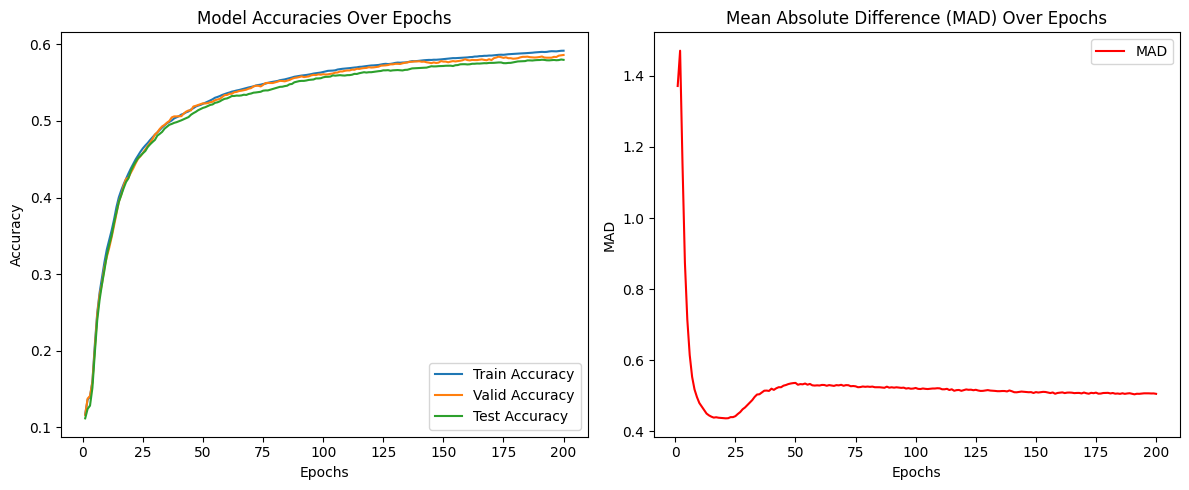

In [68]:
import matplotlib.pyplot as plt

# Plot performance curves
epochs_range = range(1, 1 + epochs)

# Plot for Accuracies
plt.figure(figsize=(12, 5))

# Plot for Accuracy
plt.subplot(1, 2, 1)  # Two plots, this is the first
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, valid_accuracies, label='Valid Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracies Over Epochs')
plt.legend()

# Plot for MAD
plt.subplot(1, 2, 2)  # Two plots, this is the second
plt.plot(epochs_range, mad_values, label='MAD', color='red')
plt.xlabel('Epochs')
plt.ylabel('MAD')
plt.title('Mean Absolute Difference (MAD) Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
data.y

tensor([[ 4],
        [ 5],
        [28],
        ...,
        [10],
        [ 4],
        [ 1]])